# [CIS442D Advanced Business Analysis]
## Basemap Example 1 _ Plot the home of the winner of the English Premier League.

In this example, we will plot the home of the EPL winnner on the map by using basemap package.

The data source is extracted from European Soccer Database and you can download the dataset from the following link.

(URL : https://www.kaggle.com/hugomathien/soccer/downloads/soccer.zip)

In [1]:
#%% Import Module and Set Directory
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sqlalchemy import create_engine # database connection
import sqlite3

In [2]:
# Load Data
with sqlite3.connect('database.sqlite') as engine:
    matches = pd.read_sql_query('SELECT * FROM Match where league_id = 1729 ;', engine)
    # Load data related to English Premier League only (League ID : 1729)
matches = matches[matches.columns[:11]]  # Drop the useless columns
teams = pd.read_sql_query('SELECT * FROM Team;', engine)  # Load Team information
team_stat = pd.read_sql_query('SELECT * FROM Team_Attributes;', engine)  # Load Team attributes information

In [3]:
# Data Cleansing : 

# Sort out useful data and give label to each matches

# Aggregate stats of teams into mean value
team_stat = team_stat.groupby('team_api_id').mean().reset_index()
# Add team names & stats for each matches
matches = pd.merge(left=matches, right=teams, how='left', 
                   left_on='home_team_api_id', right_on='team_api_id')
matches = pd.merge(left=matches, right=teams, how='left', 
                   left_on='away_team_api_id', right_on='team_api_id')
# Drop useless information from the data frame and rename for convenience
matches = matches.drop(['country_id','league_id','id_y', 'team_api_id_x',
                        'team_fifa_api_id_x', 'team_short_name_x', 'id', 
                        'team_api_id_y', 'team_fifa_api_id_y', 
                        'match_api_id', 'team_short_name_y'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name_x':'home_team', 
                        'team_long_name_y':'away_team'}, inplace=True)
# Merge with home team stats
matches = pd.merge(left=matches, right=team_stat, how='left', 
                   left_on= 'home_team_api_id', right_on='team_api_id')
matches = matches.drop(['team_api_id','team_fifa_api_id','id'], axis = 1)
# Merge with away team stats
matches = pd.merge(left=matches, right=team_stat, how='left', 
                   left_on= 'away_team_api_id', right_on='team_api_id')
matches = matches.drop(['team_api_id','team_fifa_api_id','id'], axis = 1)


# Give each game labels in accordance with the matching results.

'''
   - Win = 1
   - Lose = -1
   - Draw = 0
'''

res = pd.DataFrame(np.zeros((len(matches),2)))
for i in range(len(matches)):
    if matches['home_team_goal'][i] > matches['away_team_goal'][i]:  # in case of win
        res.iloc[i][1] = 1
    elif matches['home_team_goal'][i] < matches['away_team_goal'][i]:  # in case of lose
        res.iloc[i][1] = -1
    else:
        res.iloc[i][1] = 0  # in case of draw      
res_colnames = ['match_id','label']
res.columns = res_colnames
res['match_id'] = matches['match_id']
matches = pd.merge(left=matches, right=res, how='left', left_on='match_id',
                   right_on='match_id')

# Create table matching team name with the city where the team is based

teampoint =matches.groupby(['home_team']).sum()['label']
teamlist = pd.DataFrame(teampoint.index)  # Sort out teams from the matches' list
citylist = pd.DataFrame(['London', 'Birmingham','Birmingham','Blackburn with Darwen','Blackppol'
            ,'Bolton','Bournemouth','Burnley','Cardiff','London','London','Liverpool',
            'London','Hull','Leicester','Liverpool','Manchester','Manchester','Middlesbrough',
            'Newcastle','Norwich','Portsmouth','London','Reading','Southamton',
            'Stock-on-trent','Sunderland','Swansea','London','Watford','West bromwich',
            'West ham', 'Wigan','Wolverhampton'])
team_city = pd.concat([teamlist,citylist],axis=1)
team_city.columns = ['team','city']
# Give coordinate of each city
cordlist = {'London':(51.5073509,-0.127758299),
            'Birmingham':(52.48624299999999,-1.8904009999999971),
            'Blackburn with Darwen':(53.748575,-2.487528999999995),
            'Blackpool':(53.8175053,-3.035674800000038),
            'Bolton':(53.57686469999999,-2.4282192000000578),
            'Bournemouth':(50.719164,-1.8807689999999866),
            'Burnley':(53.7892877,-2.2405034999999316),
            'Cardiff':(51.48158100000001,-3.1790899999999738),
            'Liverpool':(53.4083714,-2.9915726000000404),
            'Hull':(53.7456709,-0.3367412999999715),
            'Leicester':(52.6368778,-1.1397591999999577),
            'Manchester':(53.4807593,-2.2426305000000184),
            'Middlesbrough':(54.574227,-1.234956000000011),
            'Newcastle':(54.978252,-1.6177800000000389),
            'Norwich':(52.6308859,1.2973550000000387),
            'Portsmouth':(50.8197675,-1.0879769000000579),
            'Reading':(51.4542645,-0.9781302999999753),
            'Southamton':(50.9097004,-1.404350900000054),
            'Stock-on-trent':(53.00266799999999,-2.179403999999977),
            'Sunderland':(54.90686899999999,-1.3838009999999485),
            'Swansea':(51.62143999999999,-3.9436459999999443),
            'Watford':(51.65648899999999,-0.39031999999997424),
            'West bromwich':(52.517664,-1.9951590000000579),
            'West ham':(51.538265,0.014525000000048749),
            'Wigan':(53.5450645,-2.6325074000000086),
            'Wolverhampton':(52.586973,-2.128820000000019)} 

In [4]:
# Create Seasonal Rank & Point Data

point = pd.DataFrame(np.zeros((len(matches),8)))

# Give points based on the real results
for i in range(len(matches)):
    if matches['home_team_goal'][i] > matches['away_team_goal'][i]:
        point.iloc[i][6] = 3
        point.iloc[i][7] = 0
    elif matches['home_team_goal'][i] < matches['away_team_goal'][i]:
        point.iloc[i][6] = 0
        point.iloc[i][7] = 3        
    else:
        point.iloc[i][6] = 1
        point.iloc[i][7] = 1
        
point_colnames = ['match_id', 'home_team', 'away_team','season','stage','date' ,'home_point', 'away_point']

point.columns = point_colnames
for i in point_colnames[0:6]:
    point[i] = matches[i]

point.head()

,match_id,home_team,away_team,season,stage,date,home_point,away_point
0,1729,Manchester United,Newcastle United,2008/2009,1,2008-08-17 00:00:00,1.0,1.0
1,1730,Arsenal,West Bromwich Albion,2008/2009,1,2008-08-16 00:00:00,3.0,0.0
2,1731,Sunderland,Liverpool,2008/2009,1,2008-08-16 00:00:00,0.0,3.0
3,1732,West Ham United,Wigan Athletic,2008/2009,1,2008-08-16 00:00:00,3.0,0.0
4,1733,Aston Villa,Manchester City,2008/2009,1,2008-08-17 00:00:00,3.0,0.0


In [5]:
# Create Table showing points and ranks
home_point = point.groupby(['season','home_team']).sum()['home_point']
away_point = point.groupby(['season','away_team']).sum()['away_point']
total_point = home_point + away_point

In [7]:
# Show Results

# Create function to plot city

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

def plot_city(winner):
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    lllat = 49.8; urlat = 55.5; lllon = -7.7; urlon = 2.7
    m = Basemap(ax=ax, projection = 'stere', lon_0 = (urlon+lllon)/2,
                lat_0 = (urlat+lllat)/2, llcrnrlat = lllat, urcrnrlat = urlat,
                llcrnrlon = lllon, urcrnrlon = urlon, resolution = 'l')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = 'coral')
    m.drawmapboundary()
    
    winner_city = team_city['city'][team_city.team[team_city.team == winner].index.tolist()[0]]
    lon1, lat1 = cordlist[winner_city]
    x1,y1 = m(lat1, lon1)
    m.plot(x1, y1, 'bo', markersize=24)
    label1 = winner + '(' + winner_city + ')'
    plt.text(x1-50000, y1+30000, label1)
    red_patch = mpatches.Patch(color='blue', label='Winner on this Season')
    plt.legend(handles=[red_patch])    
    plt.show()

Season (20xx/20xx) : 2012/2013
Remark: ax.ishold function issue below is now being handled in basemap master.
2012/2013


/Users/Woojin/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/Woojin/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/Woojin/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Woojin/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


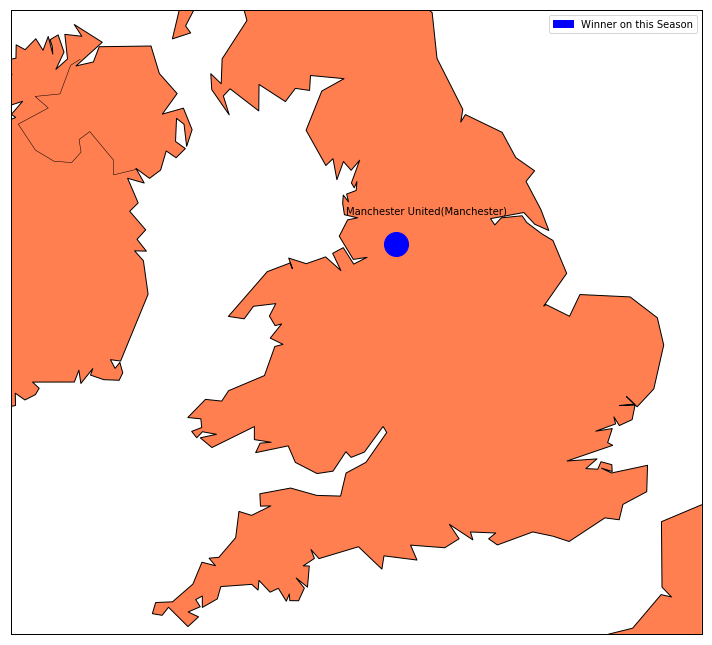

In [8]:
# Choose which season want to see

season = input('Season (20xx/20xx) : ')
season_table = pd.DataFrame(total_point[season])
del season_table.index.name
rank = pd.Series(np.arange(1,21), index = total_point[season].sort_values(ascending=False).keys())
season_table.columns = ['Result']
season_table['Result'] = season_table.Result.map(str) + ' (' + rank.map(str) + ')'
season_table = season_table.sort_values(['Result'], ascending=False)

print('Remark: ax.ishold function issue below is now being handled in basemap master.')
print(season)
plot_city(season_table.index[0])